## Improving Leadtime: Exploratory Data Analysis

The stakeholder describes the order process as follows:

Orders are received, processed and made ready to ship within 3 days. Orders can leave the warehouse on the fourth day if theres a truck (Monday, Wednesday, Friday). Otherwise, orders have to wait for the next day. Lastly, delivery takes on average 3 days.

Putting this together, average lead time is hypothesized to be 7,4 days.

Additionally, customers can pay for express shipping. Express orders are supposedly shipped the day they are made ready to ship.



In [3]:
## IMPORT

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
## GET THE PREPARED DATASETS

df_lead = pd.read_csv("data/leadtime.csv")
df_warehouse = pd.read_csv("data/warehouse.csv")
df_delivery = pd.read_csv("data/delivery.csv")
df_pickup = pd.read_csv("data/pickup.csv")

## this gives us data for leadtime (order-->arrival), warehouse (order-->readytoship), pickup (readytoshhip-->ontruck) and delivery (ontruck-->arrival)


### Leadtime

Expected leadtime is ~7,4 days per order (not accounting for express shipping which should improve the leadtime even further)

In [5]:
## CONVERT TO DATETIME

df_lead["arrival_scan_date"] = pd.to_datetime(df_lead["arrival_scan_date"])

df_lead["order_date"] = pd.to_datetime(df_lead["order_date"])

count                           75
mean               7 days 01:16:48
std      2 days 03:43:46.892823810
min                3 days 00:00:00
25%                5 days 00:00:00
50%                7 days 00:00:00
75%                8 days 00:00:00
max               13 days 00:00:00
Name: lead_time, dtype: object

In [6]:
## Getting the lead time

df_lead["lead_time"] = df_lead["arrival_scan_date"] - df_lead["order_date"]
lead_time_analysis = df_lead["lead_time"].describe()
mean_lead_time = df_lead["lead_time"].describe()["mean"]


print(f"""Full Analysis:
      {lead_time_analysis} \n\n""")

print(f"Mean leadtime is {mean_lead_time}")

Full Analysis:
      count                           333
mean     10 days 20:02:09.729729729
std       2 days 20:41:39.045324279
min                 3 days 00:00:00
25%                 9 days 00:00:00
50%                11 days 00:00:00
75%                13 days 00:00:00
max                17 days 00:00:00
Name: lead_time, dtype: object 


Mean leadtime is 10 days 20:02:09.729729729


In [71]:
#getting the leadtime for express shipments
df_lead_express = df_lead[df_lead["ship_mode"] == "Express"]

df_lead_express["lead_time"].describe()

count                           75
mean               7 days 01:16:48
std      2 days 03:43:46.892823810
min                3 days 00:00:00
25%                5 days 00:00:00
50%                7 days 00:00:00
75%                8 days 00:00:00
max               13 days 00:00:00
Name: lead_time, dtype: object

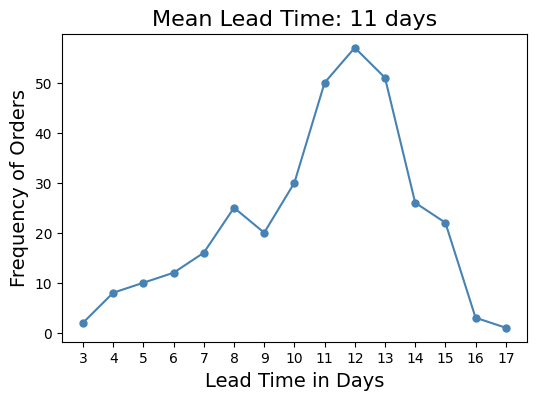

In [7]:
## INITIAL VISUALISATION: LINEPLOT

#Preparing the information to be visualised: amount of each duration an order has taken to be delivered
duration_counts = df_lead["lead_time"].value_counts().sort_index()
#this gives us only the numbers (3-17) on the x-axis, instead of "x days" per point, improving readability
duration_counts.index = duration_counts.index.days

#plot
plt.figure(figsize=(6, 4))
#we use typecasting, because matplotlib automatically applies a tick locator and formatter to numerical data
plt.plot(duration_counts.index.astype(str), duration_counts.values, marker="o", color="steelblue", linestyle="-", markersize=5)

plt.title("Mean Lead Time: 11 days", fontsize=16)
plt.xlabel("Lead Time in Days", fontsize=14)
plt.ylabel("Frequency of Orders", fontsize=14)

plt.show()

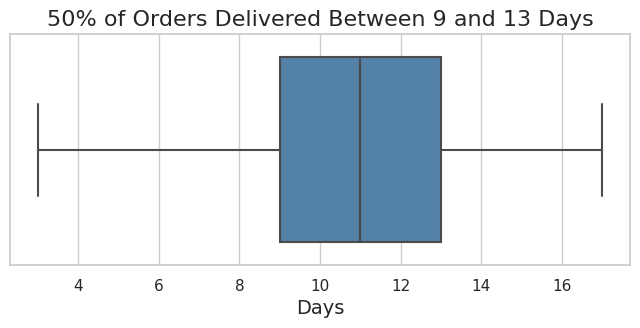

In [8]:
# INIT VIS: BOXPLOT
sns.set_theme(style="whitegrid")

# plot
plt.figure(figsize=(8, 3))
#because lead_time is a time delta, we have to convert again. For a floating representation we would do .dt.total_seconds().div(86400), but its not needed here
sns.boxplot(x=df_lead["lead_time"].dt.days, color="steelblue", linewidth=1.5)

plt.title("50% of Orders Delivered Between 9 and 13 Days", fontsize=16)
plt.xlabel("Days", fontsize=14)

plt.show()

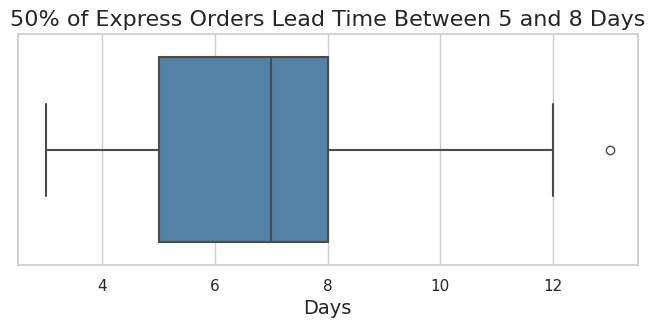

In [75]:
# INIT VIS: BOXPLOT FOR EXPRESS
sns.set_theme(style="whitegrid")

# plot
plt.figure(figsize=(8, 3))
#because lead_time is a time delta, we have to convert again. For a floating representation we would do .dt.total_seconds().div(86400), but its not needed here
sns.boxplot(x=df_lead_express["lead_time"].dt.days, color="steelblue", linewidth=1.5)

plt.title("50% of Express Orders Lead Time Between 5 and 8 Days", fontsize=16)
plt.xlabel("Days", fontsize=14)

plt.show()

### Result: Average Actual Lead Time of 11 days, higher by 4 days than the expected average of 7 days.

Expectations regarding the average lead time are 57% off, or measured absolutely, by a margin of 4 whole days.

Less than 25% of orders fall within the range of what the stakeholder expected would be normal, or put differently, more than 75% of orders are taking too long.

50% of orders take 2-6 days too long, whereas 25% of orders take 7-10 days too long.


### New task: Locate the problem

- we go through each consecutive timespan to determine the contribution to the leadtime and find areas of improvement
- we might also look at the timespan between *order date* and the *on truck scan*, as this one has the most datapoints.
- even if we find a problem in another timespan, it would need to be corroborated by more data.

### Ordered --> Ready to Ship

According to the stakeholder, orders are processed within 3 days. We test this hypothesis:

In [9]:
## Convert to DT
df_warehouse["order_date"] = pd.to_datetime(df_warehouse["order_date"])
df_warehouse["ready_to_ship_date"] = pd.to_datetime(df_warehouse["ready_to_ship_date"])

# getting the processing time
df_warehouse["processing_time"] = df_warehouse["ready_to_ship_date"] - df_warehouse["order_date"]

In [10]:
#results (no differentiation between shipmodes): ~ 4 days
df_warehouse["processing_time"].describe()

count                          204
mean     4 days 04:14:07.058823529
std      1 days 23:16:29.025426269
min                0 days 00:00:00
25%                3 days 00:00:00
50%                4 days 00:00:00
75%                6 days 00:00:00
max                8 days 00:00:00
Name: processing_time, dtype: object

In [11]:
#non-express warehousetime: ~ 5 days
df_warehouse[df_warehouse["ship_mode"] != "Express"]["processing_time"].describe()

count                          151
mean     4 days 22:15:05.960264900
std      1 days 10:37:27.519687470
min                2 days 00:00:00
25%                4 days 00:00:00
50%                5 days 00:00:00
75%                6 days 00:00:00
max                8 days 00:00:00
Name: processing_time, dtype: object

<Axes: xlabel='processing_time'>

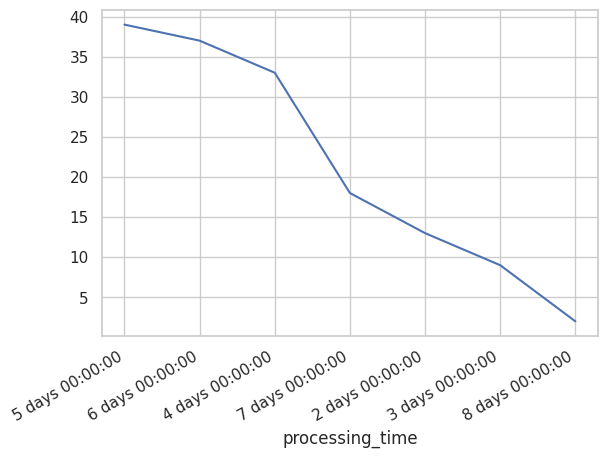

In [48]:
df_warehouse[df_warehouse["ship_mode"] != "Express"]["processing_time"].value_counts().plot()

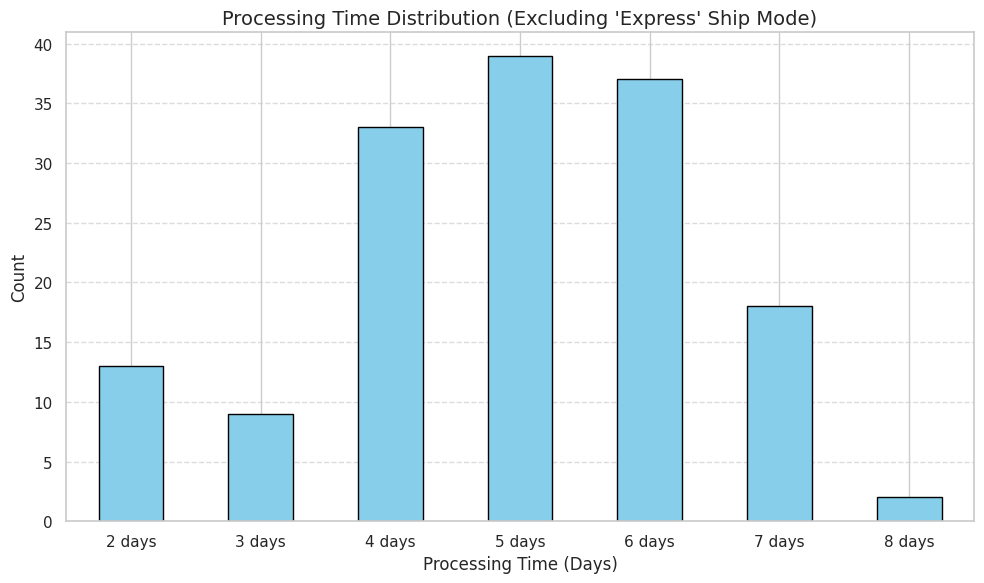

In [ ]:
# Filter the DataFrame to exclude rows with "Express" ship mode
filtered_data = df_warehouse[df_warehouse["ship_mode"] != "Express"]

# Count the occurrences of each processing time
processing_time_counts = filtered_data["processing_time"].value_counts()

# Convert the index to days only
processing_time_counts.index = processing_time_counts.index.days

# Sort the index to ensure chronological order
processing_time_counts = processing_time_counts.sort_index()

# Plot the data
plt.figure(figsize=(10, 6))  # Set the figure size
processing_time_counts.plot(kind="bar", color="skyblue", edgecolor="black")

# Add labels and title for better readability
plt.title("Processing Time Distribution (Excluding 'Express' Ship Mode)", fontsize=14)
plt.xlabel("Processing Time (Days)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add a grid for clarity

# Format x-axis labels to show only days
plt.gca().set_xticklabels([f"{x} days" for x in processing_time_counts.index])

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()



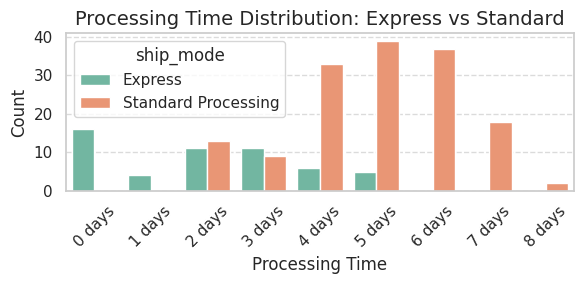

In [65]:
# Get the sorted unique values of processing_time
sorted_processing_times = sorted(df_warehouse['processing_time'].unique())

# Create the plot
plt.figure(figsize=(6, 3))
sns.countplot(data=df_warehouse, x="processing_time", hue="ship_mode", palette="Set2", order=sorted_processing_times)

# Customize the plot
plt.title("Processing Time Distribution: Express vs Standard", fontsize=14)
plt.xlabel("Processing Time", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Rotate x-axis labels if needed (e.g., for datetime objects)
plt.xticks(rotation=45)

# Add gridlines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [13]:
#express warehousetime: 2 days
df_warehouse[df_warehouse["ship_mode"] == "Express"]["processing_time"].describe()

count                           53
mean     2 days 00:54:20.377358490
std      1 days 16:28:44.363545098
min                0 days 00:00:00
25%                0 days 00:00:00
50%                2 days 00:00:00
75%                3 days 00:00:00
max                5 days 00:00:00
Name: processing_time, dtype: object

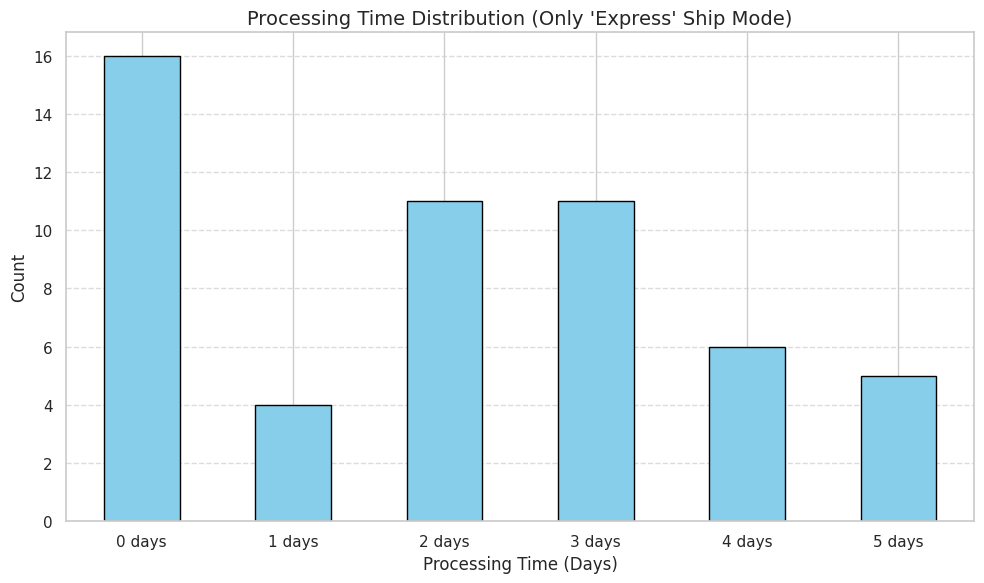

In [52]:
# Filter the DataFrame to exclude rows with "Express" ship mode
filtered_data_express = df_warehouse[df_warehouse["ship_mode"] == "Express"]

# Count the occurrences of each processing time
processing_time_counts_express = filtered_data_express["processing_time"].value_counts()

# Convert the index to days only
processing_time_counts_express.index = processing_time_counts_express.index.days

# Sort the index to ensure chronological order
processing_time_counts_express = processing_time_counts_express.sort_index()

# Plot the data
plt.figure(figsize=(10, 6))  # Set the figure size
processing_time_counts_express.plot(kind="bar", color="skyblue", edgecolor="black")

# Add labels and title for better readability
plt.title("Processing Time Distribution (Only 'Express' Ship Mode)", fontsize=14)
plt.xlabel("Processing Time (Days)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add a grid for clarity

# Format x-axis labels to show only days
plt.gca().set_xticklabels([f"{x} days" for x in processing_time_counts_express.index])

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

### RESULT: Actual processing time is 4 days (across shipmodes) --> 1 day more than the Hypothesis

- However, for express-orders, the mean processing time is 2 days, so 1 day less than the Hypothesis. As express-orders are supposed to be shipped the day they are ready, the ship_mode should NOT influence the processing time. Nevertheless, it speeds the processing time up by 2 full days, or improves efficiency by 100% compared to the general processing time. Compared to non-express orders, express orders are 250% faster.

- For future improvements, whatever protocol is in place for handling express-orders, it could be applied to all orders, improving the leadtime by 3 days. 

- Or, charge customers for this faster processing along the lines of a VIP-lane (because right now, they pay for their orders to be shipped when the order is ready, but what they get is 250% faster processing)

### Ready to Ship --> On Truck Scan

- according to the stakeholder's hypothesis it should be 0-2 days, because there are trucks on Monday, Wednesday and Friday
- orders that are ready to ship on Tuesday and Thursday should have a wait-time of 1 day. 
- orders that are ready to ship on Monday and Wednesday should have to wait 2 days for the next truck-day (or 0, if the order is ready to be shipped prior to the truck being loaded)
- orders that are ready to ship on friday either have a wait-time of 0, or will be shipped on the next Monday with a wait-time of 3 days.
- unclear how express shippings interefere with this: Do express shippings on non-truck days (Tuesday and Thursday) still get shipped on that day? 

In [14]:
## PREPARATION: we need to convert to datetime and get the days for both ready_to_ship and pickup/ontruck, as well as the timespan ready_to_ship-->pick_up

#convert
df_pickup["ready_to_ship_date"] = pd.to_datetime(df_pickup["ready_to_ship_date"])
df_pickup["pickup_date"] = pd.to_datetime(df_pickup["pickup_date"])

#weekdays for ready_to_ship
df_pickup["days_when_ready"] = pd.to_datetime(df_pickup["ready_to_ship_date"]).dt.day_name()

#weekdays for pickup
df_pickup["days_pickup"] = pd.to_datetime(df_pickup["pickup_date"]).dt.day_name()

#get the duration for ready_to_ship --> pick_up
df_pickup["ready_to_pickup"] = df_pickup["pickup_date"] - df_pickup["ready_to_ship_date"]
df_pickup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   order_id            204 non-null    object         
 1   ready_to_ship_date  204 non-null    datetime64[ns] 
 2   pickup_date         204 non-null    datetime64[ns] 
 3   ship_mode           204 non-null    object         
 4   days_when_ready     204 non-null    object         
 5   days_pickup         204 non-null    object         
 6   ready_to_pickup     204 non-null    timedelta64[ns]
dtypes: datetime64[ns](2), object(4), timedelta64[ns](1)
memory usage: 11.3+ KB


In [15]:
df_pickup["ready_to_pickup"].describe()

count                          204
mean     1 days 13:45:52.941176470
std      0 days 22:50:34.321824212
min                0 days 00:00:00
25%                1 days 00:00:00
50%                2 days 00:00:00
75%                2 days 00:00:00
max                3 days 00:00:00
Name: ready_to_pickup, dtype: object

In [66]:
df_pickup[df_pickup["ship_mode"] == "Express"]["ready_to_pickup"].describe()

count                           53
mean     0 days 09:30:33.962264150
std      0 days 12:45:05.416738350
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                1 days 00:00:00
max                2 days 00:00:00
Name: ready_to_pickup, dtype: object

In [16]:
##Let's look at express first: Do Express-Orders get shipped when they are ready?

#ready_to_pickup should always be "0 days"

df_pickup[df_pickup["ship_mode"] == "Express"]["ready_to_pickup"].value_counts()

ready_to_pickup
0 days    33
1 days    19
2 days     1
Name: count, dtype: int64

In [17]:
# according to the stakeholder, no trucks are coming on tuesday and thursday. What about express-orders that are ready to be picked up on those days?

df_pickup[(df_pickup["ship_mode"] == "Express") & ((df_pickup["days_when_ready"] == "Tuesday") | (df_pickup["days_when_ready"] == "Thursday"))]

#with 1 exception, express-orders on no-truck days are shipped the next day
#thats something, but it's not what customers pay for (shipped when ready no matter the day)

,order_id,ready_to_ship_date,pickup_date,ship_mode,days_when_ready,days_pickup,ready_to_pickup
4,CA-2019-158099,2019-09-05,2019-09-06,Express,Thursday,Friday,1 days
5,CA-2019-132143,2019-09-05,2019-09-06,Express,Thursday,Friday,1 days
47,US-2019-147340,2019-09-24,2019-09-25,Express,Tuesday,Wednesday,1 days
54,CA-2019-132479,2019-09-26,2019-09-27,Express,Thursday,Friday,1 days
68,US-2020-145597,2020-11-05,2020-11-06,Express,Thursday,Friday,1 days
70,CA-2020-147760,2020-11-05,2020-11-06,Express,Thursday,Friday,1 days
73,US-2020-105998,2020-11-05,2020-11-06,Express,Thursday,Friday,1 days
74,CA-2020-167227,2020-11-05,2020-11-06,Express,Thursday,Friday,1 days
93,CA-2020-162096,2020-11-10,2020-11-12,Express,Tuesday,Thursday,2 days
101,US-2020-116659,2020-11-12,2020-11-13,Express,Thursday,Friday,1 days


In [18]:
#now for truck-days
df_pickup[(df_pickup["ship_mode"] == "Express") & ~((df_pickup["days_when_ready"] == "Tuesday") | (df_pickup["days_when_ready"] == "Thursday"))]

#with two exceptions this works as intended. Those two exceptions have trucks on non-truck days, with 2019-09-02 being labor day, and 2020-11-11 in the middle of covid-curfews etc.


,order_id,ready_to_ship_date,pickup_date,ship_mode,days_when_ready,days_pickup,ready_to_pickup
0,CA-2019-116540,2019-09-02,2019-09-03,Express,Monday,Tuesday,1 days
1,CA-2019-129847,2019-09-04,2019-09-04,Express,Wednesday,Wednesday,0 days
2,CA-2019-129630,2019-09-04,2019-09-04,Express,Wednesday,Wednesday,0 days
9,US-2019-101616,2019-09-06,2019-09-06,Express,Friday,Friday,0 days
17,CA-2019-145240,2019-09-09,2019-09-09,Express,Monday,Monday,0 days
24,CA-2019-110023,2019-09-11,2019-09-11,Express,Wednesday,Wednesday,0 days
29,CA-2019-143476,2019-09-13,2019-09-13,Express,Friday,Friday,0 days
35,CA-2019-153157,2019-09-16,2019-09-16,Express,Monday,Monday,0 days
41,CA-2019-158610,2019-09-23,2019-09-23,Express,Monday,Monday,0 days
64,US-2020-168116,2020-11-04,2020-11-04,Express,Wednesday,Wednesday,0 days


In [19]:
## 
df_pickup["ready_to_pickup"].value_counts()

ready_to_pickup
2 days    82
1 days    55
3 days    34
0 days    33
Name: count, dtype: int64

In [20]:
df_pickup["ready_to_pickup"].describe()

count                          204
mean     1 days 13:45:52.941176470
std      0 days 22:50:34.321824212
min                0 days 00:00:00
25%                1 days 00:00:00
50%                2 days 00:00:00
75%                2 days 00:00:00
max                3 days 00:00:00
Name: ready_to_pickup, dtype: object

In [21]:
#Let's check if there really are trucks only on truckdays:

#percentage of non-truck days, that did have a truck nonetheless
len(df_pickup[df_pickup["days_pickup"].isin(["Thursday", "Tuesday"])]) / len(df_pickup) * 100

8.823529411764707

In [22]:
# lets see how many orders are shipped when they are ready on the same day

df_pickup[df_pickup["days_when_ready"] == df_pickup["days_pickup"]] 

#only express orders are shipped when they are ready




,order_id,ready_to_ship_date,pickup_date,ship_mode,days_when_ready,days_pickup,ready_to_pickup
1,CA-2019-129847,2019-09-04,2019-09-04,Express,Wednesday,Wednesday,0 days
2,CA-2019-129630,2019-09-04,2019-09-04,Express,Wednesday,Wednesday,0 days
9,US-2019-101616,2019-09-06,2019-09-06,Express,Friday,Friday,0 days
17,CA-2019-145240,2019-09-09,2019-09-09,Express,Monday,Monday,0 days
24,CA-2019-110023,2019-09-11,2019-09-11,Express,Wednesday,Wednesday,0 days
29,CA-2019-143476,2019-09-13,2019-09-13,Express,Friday,Friday,0 days
35,CA-2019-153157,2019-09-16,2019-09-16,Express,Monday,Monday,0 days
41,CA-2019-158610,2019-09-23,2019-09-23,Express,Monday,Monday,0 days
64,US-2020-168116,2020-11-04,2020-11-04,Express,Wednesday,Wednesday,0 days
66,CA-2020-121160,2020-11-04,2020-11-04,Express,Wednesday,Wednesday,0 days


In [23]:
#are there never non-express orders ready on truck-days?

df_pickup[(df_pickup["days_when_ready"] == "Monday") & (df_pickup["days_pickup"] != "Monday")]["ship_mode"].value_counts()

#df_pickup[df_pickup["days_when_ready"] == df_pickup["days_pickup"]] 


ship_mode
Standard Processing    74
Express                 1
Name: count, dtype: int64

In [24]:
#we can ignore the one express shipping line
df_pickup[(df_pickup["days_when_ready"] == "Monday") & (df_pickup["days_pickup"] != "Monday")] 


,order_id,ready_to_ship_date,pickup_date,ship_mode,days_when_ready,days_pickup,ready_to_pickup
0,CA-2019-116540,2019-09-02,2019-09-03,Express,Monday,Tuesday,1 days
10,CA-2019-169971,2019-09-09,2019-09-11,Standard Processing,Monday,Wednesday,2 days
11,CA-2019-142524,2019-09-09,2019-09-11,Standard Processing,Monday,Wednesday,2 days
12,CA-2019-144764,2019-09-09,2019-09-11,Standard Processing,Monday,Wednesday,2 days
13,US-2019-147711,2019-09-09,2019-09-11,Standard Processing,Monday,Wednesday,2 days
...,...,...,...,...,...,...,...
190,US-2020-109610,2020-11-30,2020-12-02,Standard Processing,Monday,Wednesday,2 days
191,CA-2020-166436,2020-11-30,2020-12-02,Standard Processing,Monday,Wednesday,2 days
192,CA-2020-164028,2020-11-30,2020-12-02,Standard Processing,Monday,Wednesday,2 days
193,CA-2020-117702,2020-11-30,2020-12-02,Standard Processing,Monday,Wednesday,2 days


In [25]:
# 80% of orders that are ready to be picked up on mondays are not picked up that day.

len(df_pickup[(df_pickup["days_when_ready"] == "Monday") & (df_pickup["days_pickup"] != "Monday")]) / len(df_pickup[df_pickup["days_when_ready"] == "Monday"]) *100

80.64516129032258

In [26]:
# 74% of order that are ready to be picked up on wednesdays are not picked up that day
len(df_pickup[(df_pickup["days_when_ready"] == "Wednesday") & (df_pickup["days_pickup"] != "Wednesday")]) / len(df_pickup[df_pickup["days_when_ready"] == "Wednesday"]) *100

73.91304347826086

In [27]:
df_pickup[(df_pickup["days_when_ready"] == "Wednesday") & (df_pickup["days_pickup"] != "Wednesday")]

,order_id,ready_to_ship_date,pickup_date,ship_mode,days_when_ready,days_pickup,ready_to_pickup
22,CA-2019-149223,2019-09-11,2019-09-13,Standard Processing,Wednesday,Friday,2 days
23,CA-2019-133123,2019-09-11,2019-09-13,Standard Processing,Wednesday,Friday,2 days
52,CA-2019-134516,2019-09-25,2019-09-27,Standard Processing,Wednesday,Friday,2 days
61,CA-2019-163202,2019-10-02,2019-10-04,Standard Processing,Wednesday,Friday,2 days
65,US-2020-163790,2020-11-04,2020-11-06,Standard Processing,Wednesday,Friday,2 days
96,CA-2020-154109,2020-11-11,2020-11-13,Standard Processing,Wednesday,Friday,2 days
97,US-2020-155425,2020-11-11,2020-11-12,Express,Wednesday,Thursday,1 days
98,CA-2020-161018,2020-11-11,2020-11-13,Standard Processing,Wednesday,Friday,2 days
131,US-2020-124926,2020-11-18,2020-11-20,Standard Processing,Wednesday,Friday,2 days
132,CA-2020-164168,2020-11-18,2020-11-20,Standard Processing,Wednesday,Friday,2 days


In [28]:
# 71% of orders that are ready on fridays are not picked up that day.
len(df_pickup[(df_pickup["days_when_ready"] == "Friday") & (df_pickup["days_pickup"] != "Friday")]) / len(df_pickup[df_pickup["days_when_ready"] == "Friday"]) *100

70.96774193548387

In [29]:
df_pickup[(df_pickup["days_when_ready"] == "Friday") & (df_pickup["days_pickup"] != "Friday")]

,order_id,ready_to_ship_date,pickup_date,ship_mode,days_when_ready,days_pickup,ready_to_pickup
6,CA-2019-126732,2019-09-06,2019-09-09,Standard Processing,Friday,Monday,3 days
7,CA-2019-106950,2019-09-06,2019-09-09,Standard Processing,Friday,Monday,3 days
8,CA-2019-130407,2019-09-06,2019-09-09,Standard Processing,Friday,Monday,3 days
27,CA-2019-112893,2019-09-13,2019-09-16,Standard Processing,Friday,Monday,3 days
28,CA-2019-121223,2019-09-13,2019-09-16,Standard Processing,Friday,Monday,3 days
63,CA-2019-106243,2019-10-04,2019-10-07,Standard Processing,Friday,Monday,3 days
76,CA-2020-130834,2020-11-06,2020-11-09,Standard Processing,Friday,Monday,3 days
77,CA-2020-127782,2020-11-06,2020-11-09,Standard Processing,Friday,Monday,3 days
103,CA-2020-159667,2020-11-13,2020-11-16,Standard Processing,Friday,Monday,3 days
104,CA-2020-107174,2020-11-13,2020-11-16,Standard Processing,Friday,Monday,3 days


In [30]:
## whats with the orders that take 3 days be shipped?

df_pickup[df_pickup["ready_to_pickup"] == "3 days"]

,order_id,ready_to_ship_date,pickup_date,ship_mode,days_when_ready,days_pickup,ready_to_pickup
6,CA-2019-126732,2019-09-06,2019-09-09,Standard Processing,Friday,Monday,3 days
7,CA-2019-106950,2019-09-06,2019-09-09,Standard Processing,Friday,Monday,3 days
8,CA-2019-130407,2019-09-06,2019-09-09,Standard Processing,Friday,Monday,3 days
27,CA-2019-112893,2019-09-13,2019-09-16,Standard Processing,Friday,Monday,3 days
28,CA-2019-121223,2019-09-13,2019-09-16,Standard Processing,Friday,Monday,3 days
63,CA-2019-106243,2019-10-04,2019-10-07,Standard Processing,Friday,Monday,3 days
76,CA-2020-130834,2020-11-06,2020-11-09,Standard Processing,Friday,Monday,3 days
77,CA-2020-127782,2020-11-06,2020-11-09,Standard Processing,Friday,Monday,3 days
78,CA-2020-121615,2020-11-09,2020-11-12,Standard Processing,Monday,Thursday,3 days
79,CA-2020-102610,2020-11-09,2020-11-12,Standard Processing,Monday,Thursday,3 days


In [31]:
df_pickup["ready_to_pickup"].value_counts()

ready_to_pickup
2 days    82
1 days    55
3 days    34
0 days    33
Name: count, dtype: int64

In [32]:
# lets get the weekdays for ready_to_ship

df_pickup["days_when_ready"] = pd.to_datetime(df_pickup["ready_to_ship_date"]).dt.day_name()

df_pickup["days_when_ready"].value_counts()

days_when_ready
Monday       93
Friday       31
Tuesday      29
Thursday     28
Wednesday    23
Name: count, dtype: int64

In [33]:
#is it because we have many orders coming in on mondays?

df_orders = pd.read_csv("data/orders.csv")

# get weekdays for order_date
df_orders["order_date_day"] = pd.to_datetime(df_orders["order_date"]).dt.day_name()

df_orders["order_date_day"].value_counts()

order_date_day
Thursday     885
Tuesday      884
Wednesday    846
Friday       790
Monday       730
Saturday     458
Sunday       416
Name: count, dtype: int64

In [34]:
df_pickup["days_pickup"].value_counts()

days_pickup
Wednesday    93
Friday       53
Monday       40
Thursday     17
Tuesday       1
Name: count, dtype: int64

### Ready to Ship --> PickUp: Key Insights

- Average 1.5 days time from orders being ready to ship until they are on the trucks. 
- Express orders work only on truck-days. Express orders that are ready to ship on non-truck days will be shipped on the next day.

- (No non-express orders that are ready on truck-days will be shipped on that day. They have to wait 2 days, or 3 if it is a Friday)

## PickUp --> Arrival Scan



In [35]:
df_delivery

,order_id,order_date,on_truck_scan_date,ship_mode_x,arrival_scan_date,customer_name,ship_mode_y
0,CA-2019-138933,2019-04-24,2019-04-29,Express,2019-05-03,Jack Lebron,Express
1,CA-2019-109666,2019-04-19,2019-04-29,Standard Processing,2019-05-03,Kunst Miller,Standard Processing
2,CA-2019-113061,2019-04-22,2019-04-29,Standard Processing,2019-05-06,Ed Ludwig,Standard Processing
3,CA-2019-168081,2019-04-24,2019-05-01,Standard Processing,2019-05-06,Cathy Armstrong,Standard Processing
4,US-2019-150147,2019-04-25,2019-05-01,Standard Processing,2019-05-07,John Lucas,Standard Processing
...,...,...,...,...,...,...,...
328,CA-2020-125381,2020-04-25,2020-05-01,Standard Processing,2020-05-08,Speros Goranitis,Standard Processing
329,CA-2020-129707,2020-04-25,2020-05-04,Standard Processing,2020-05-08,Larry Hughes,Standard Processing
330,US-2020-139647,2020-05-11,2020-05-13,Express,2020-05-15,Todd Sumrall,Express
331,US-2020-104451,2020-05-08,2020-05-13,Standard Processing,2020-05-15,Michelle Moray,Standard Processing


In [36]:
## PREPARATION: 

#convert
df_delivery["on_truck_scan_date"] = pd.to_datetime(df_delivery["on_truck_scan_date"])
df_delivery["arrival_scan_date"] = pd.to_datetime(df_delivery["arrival_scan_date"])

#get the duration for ontruck --> arrivalscan
df_delivery["delivery_time"] = df_delivery["arrival_scan_date"] - df_delivery["on_truck_scan_date"]
df_delivery.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   order_id            333 non-null    object         
 1   order_date          333 non-null    object         
 2   on_truck_scan_date  333 non-null    datetime64[ns] 
 3   ship_mode_x         333 non-null    object         
 4   arrival_scan_date   333 non-null    datetime64[ns] 
 5   customer_name       333 non-null    object         
 6   ship_mode_y         333 non-null    object         
 7   delivery_time       333 non-null    timedelta64[ns]
dtypes: datetime64[ns](2), object(5), timedelta64[ns](1)
memory usage: 20.9+ KB


In [37]:
df_delivery["delivery_time"].describe()

count                          333
mean     4 days 14:29:11.351351351
std      1 days 04:47:16.148329809
min                1 days 00:00:00
25%                4 days 00:00:00
50%                5 days 00:00:00
75%                5 days 00:00:00
max                7 days 00:00:00
Name: delivery_time, dtype: object

### Delivery Insights

- Delivery takes ~4.5 days on average, should take 3 according to the stakeholder

# Summary

- Average Leadtime 11 days, should take 7
    - Processing time is 4 days, should be 3
    - Time to put finished orders on trucks is 1.5
    - Delivery is 4.5, should be 3

- Adding the different stages together brings us to 10 days. The difference is due to working with different non-overlapping datasets

- For Express-Shipments: processing time is 2 days, 

In [38]:
df_lead

,order_id,order_date,sales,quantity,discount,profit,arrival_scan_date,customer_name,ship_mode,lead_time
0,CA-2019-100041,2019-11-20,328.540,6,0.0,157.3777,2019-12-02,Barbara Fisher,Standard Processing,12 days
1,CA-2019-100083,2019-11-24,24.784,1,0.2,7.7450,2019-12-09,Carol Darley,Standard Processing,15 days
2,CA-2019-100244,2019-09-20,475.694,19,0.4,175.6262,2019-09-30,Greg Maxwell,Standard Processing,10 days
3,CA-2019-100468,2019-11-24,43.460,4,0.2,6.4334,2019-12-09,Alyssa Tate,Standard Processing,15 days
4,CA-2019-100510,2019-05-12,641.980,7,0.0,307.7496,2019-05-28,Harry Marie,Standard Processing,16 days
...,...,...,...,...,...,...,...,...,...,...
328,US-2020-139647,2020-05-11,209.979,7,0.7,-356.9643,2020-05-15,Todd Sumrall,Express,4 days
329,US-2020-148551,2020-01-12,760.980,5,0.8,-1141.4700,2020-01-22,David Bremer,Standard Processing,10 days
330,US-2020-158512,2020-01-12,77.760,8,0.0,35.0640,2020-01-27,Dianna Arnett,Standard Processing,15 days
331,US-2020-163195,2020-02-17,29.160,3,0.0,8.4564,2020-03-02,Lauren Leatherbury,Standard Processing,14 days


In [39]:
df_lead
df_lead["order_date_day"] = pd.to_datetime(df_lead["order_date"]).dt.day_name()


In [40]:
result = df_lead.groupby("order_date_day")["lead_time"].mean()

In [41]:
result_2 = df_lead.groupby("order_date_day")["lead_time"].agg(["mean", "median", "std"])

In [42]:
result_2

,mean,median,std
order_date_day,,,
Friday,10 days 05:50:16.216216216,10 days 00:00:00,2 days 11:58:29.170091799
Monday,11 days 01:48:40.754716981,14 days 00:00:00,3 days 13:52:16.818949455
Saturday,9 days 08:00:00,9 days 00:00:00,3 days 03:23:13.205515539
Sunday,11 days 05:27:16.363636363,11 days 12:00:00,3 days 04:54:53.187757614
Thursday,10 days 06:51:25.714285714,11 days 00:00:00,2 days 06:15:21.319102274
Tuesday,10 days 23:35:35.593220339,13 days 00:00:00,2 days 20:40:51.424292618
Wednesday,11 days 04:53:52.653061224,12 days 00:00:00,2 days 07:12:15.332150319


In [43]:
result

order_date_day
Friday      10 days 05:50:16.216216216
Monday      11 days 01:48:40.754716981
Saturday               9 days 08:00:00
Sunday      11 days 05:27:16.363636363
Thursday    10 days 06:51:25.714285714
Tuesday     10 days 23:35:35.593220339
Wednesday   11 days 04:53:52.653061224
Name: lead_time, dtype: timedelta64[ns]

In [44]:
import numpy as np

df_new = df_lead.copy()
df_new['lead_time'] = df_new['lead_time'].apply(lambda x: np.random.choice(df_new['lead_time'].dropna().values) if pd.isna(x) else x)


#df_new["processing_time"] = df_lead["lead_time"].apply(lambda x: np.random.choice(df_lead["lead_time"].dropna().values) if np.isnan(x) else x)

In [45]:
df_new

,order_id,order_date,sales,quantity,discount,profit,arrival_scan_date,customer_name,ship_mode,lead_time,order_date_day
0,CA-2019-100041,2019-11-20,328.540,6,0.0,157.3777,2019-12-02,Barbara Fisher,Standard Processing,12 days,Wednesday
1,CA-2019-100083,2019-11-24,24.784,1,0.2,7.7450,2019-12-09,Carol Darley,Standard Processing,15 days,Sunday
2,CA-2019-100244,2019-09-20,475.694,19,0.4,175.6262,2019-09-30,Greg Maxwell,Standard Processing,10 days,Friday
3,CA-2019-100468,2019-11-24,43.460,4,0.2,6.4334,2019-12-09,Alyssa Tate,Standard Processing,15 days,Sunday
4,CA-2019-100510,2019-05-12,641.980,7,0.0,307.7496,2019-05-28,Harry Marie,Standard Processing,16 days,Sunday
...,...,...,...,...,...,...,...,...,...,...,...
328,US-2020-139647,2020-05-11,209.979,7,0.7,-356.9643,2020-05-15,Todd Sumrall,Express,4 days,Monday
329,US-2020-148551,2020-01-12,760.980,5,0.8,-1141.4700,2020-01-22,David Bremer,Standard Processing,10 days,Sunday
330,US-2020-158512,2020-01-12,77.760,8,0.0,35.0640,2020-01-27,Dianna Arnett,Standard Processing,15 days,Sunday
331,US-2020-163195,2020-02-17,29.160,3,0.0,8.4564,2020-03-02,Lauren Leatherbury,Standard Processing,14 days,Monday
